In [1]:

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lasso_path, Lasso, LassoCV
from module import enrich, NaN_checker, PrincipalComponentAnalysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import KFold, GridSearchCV 

## Lasso Regularisation 

In [8]:
features_input = enrich(pd.read_csv('train.csv')).drop(['Compound', 'SMILES', 'Lab','RT'], axis=1)
RT_output = enrich(pd.read_csv('train.csv'))['RT']

We define a function that helps us to find the last non zero parameters as lambda increases. 

In [9]:
def last_non_zero_lasso_param(alphas, max_num_nonzero_coefficients, features_input, RT_output) :
    """
    Find the last non zero coefficients features.
    
    Parameters : 
    - alphas (np.array) : array containing the different values of lambda where we want to evaluate the coefficients for the different features.
    - max_num_nonzero_coefficients : maximum of the last non zero coefficients that is wanted. 
    """
    coefficients = []
    model = Lasso()
    for alpha in reversed(alphas):
        model.set_params(alpha=alpha)
        model.fit(features_input, RT_output)
        nonzero_coefficients = np.sum(model.coef_ != 0)
        if nonzero_coefficients >= max_num_nonzero_coefficients:
            break
        coefficients.append(model.coef_)
    coefficients = np.array(coefficients)
    nonzero_coefficients_indices = np.where(coefficients[-1] != 0)[0]
    selected_feature_names = features_input.columns[nonzero_coefficients_indices]
    selected_coefficients = coefficients[-1][nonzero_coefficients_indices]
    selected_coefficients_df = pd.DataFrame({'Nom de la colonne': selected_feature_names, 'Coefficient': selected_coefficients})
    return selected_coefficients_df


In [10]:
alphas = np.logspace(-6, 1, 10)
max_num_nonzero_coefficients = 35
best_features = last_non_zero_lasso_param(alphas, max_num_nonzero_coefficients, features_input, RT_output)
display(best_features)


,Nom de la colonne,Coefficient
0,ECFP_41,1.443102e-02
1,ECFP_46,5.988173e-03
2,ECFP_152,1.631917e-03
3,ECFP_262,5.778878e-02
4,ECFP_334,1.743946e-01
5,ECFP_491,6.716838e-02
6,ECFP_550,2.074654e-01
7,ECFP_592,5.963726e-02
8,ECFP_882,-1.464008e-01
9,ECFP_888,6.068475e-02


In [4]:
alphas =np.logspace(-6,1,10)
alphas_lasso, coefs_lasso, _ = lasso_path(features_input, RT_output, alphas=alphas)

lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(features_input, RT_output)

variance_explained = 1 - (lasso_cv.mse_path_.mean(axis=1) / np.var(RT_output))

fig, (ax1, ax2) = plt.subplots(2, sharex = True)
ax1.plot(np.log(alphas_lasso), variance_explained)
ax1.set_ylabel("variance explained")
ax2.plot(np.log(alphas_lasso), np.count_nonzero(coefs_lasso.T, axis =1))
ax2.set_ylabel("non zeros parameters")
ax2.set_xlabel("log(alpha)")
plt.show()


NameError: name 'features_input' is not defined

In [3]:
def tune_model(model, data):
    kf = KFold(n_splits=5, shuffle=True, random_state=5)
    param_grid = {
        'alpha': np.logspace(-30, -1, num =30)
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=kf, scoring='neg_root_mean_squared_error')
    grid_search.fit(data.drop(columns=['RT']), data['RT'])
    return grid_search

## Searching best alpha for enriched train

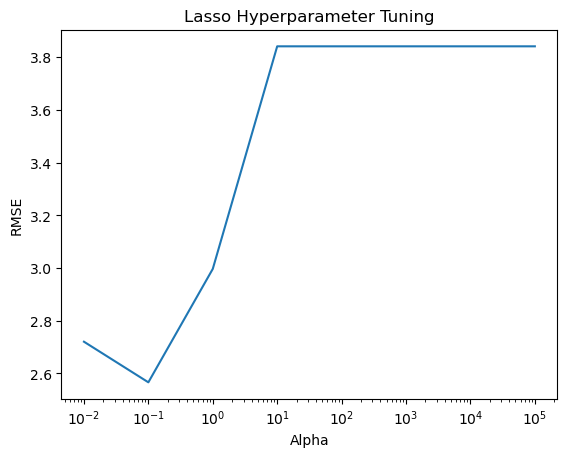

In [12]:
data1 = enrich(pd.read_csv('train.csv')).drop(['Compound', 'SMILES', 'Lab'], axis=1)
# Tune the LassoRegressor model
res1_lasso = tune_model(Lasso(max_iter = 10_000), data1)

# Plot results
plt.figure()
plt.plot(10.0**np.arange(-30, 0, 1), -res1_lasso.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Lasso Hyperparameter Tuning')
plt.show()


In [13]:
("Best Alpha:", res1_lasso.best_estimator_.alpha, "Best Parameters:", res1_lasso.best_estimator_.coef_, "Best intercept:", res1_lasso.best_estimator_.intercept_)

('Best Alpha:',
 0.1,
 'Best Parameters:',
 array([-0.,  0.,  0., ...,  0.,  0., -0.]),
 'Best intercept:',
 7.4603847907142855)

## Best alpha for PCA

c:\Users\annab\anaconda3\envs\MLCourse\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.846e+03, tolerance: 4.077e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
c:\Users\annab\anaconda3\envs\MLCourse\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.952e+03, tolerance: 4.136e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers 

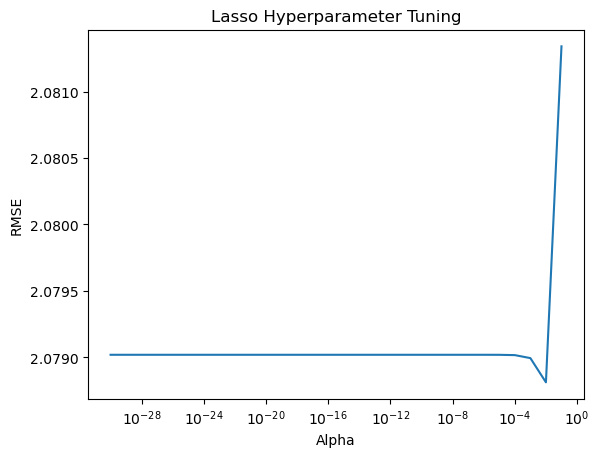

In [4]:
data2 = PrincipalComponentAnalysis(enrich(pd.read_csv('train.csv')).drop(['Compound', 'SMILES', 'Lab'], axis=1), 31)
# Tune the LassoRegressor model
res1_lasso = tune_model(Lasso(max_iter = 10_000), data2)

# Plot results
plt.figure()
plt.plot(10.0**np.arange(-30, 0, 1), -res1_lasso.cv_results_['mean_test_score'])
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('Lasso Hyperparameter Tuning')
plt.show()


In [5]:
("Best Alpha:", res1_lasso.best_estimator_.alpha, "Best Parameters:", res1_lasso.best_estimator_.coef_, "Best intercept:", res1_lasso.best_estimator_.intercept_)

('Best Alpha:',
 0.01,
 'Best Parameters:',
 array([ 0.29640773, -0.03157843, -0.01030374, -0.11103975, -0.01833125,
        -0.00818061, -0.08645307, -0.00646162,  0.09227233,  0.05377203,
        -0.10219062, -0.02395051, -0.05221508,  0.00029815,  0.08746264,
         0.02595643,  0.15042648, -0.03496693,  0.04539031,  0.03210875,
         0.08888203,  0.09902525,  0.10906048,  0.08035897, -0.14597168,
         0.04878993,  0.05774391, -0.0576832 ,  0.00275873,  0.01293928,
         0.04289228]),
 'Best intercept:',
 7.4603847907142855)